Converting the dataset to binary classification problem i.e. for all nums>1 = 1.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
dataset = pd.read_csv("heart_disease_uci.csv")

In [26]:
dataset['num'] = dataset['num'].apply(lambda x: 1 if x> 0 else 0)

In [27]:
dataset['num'].value_counts()

,count
num,
1,509
0,411


<Axes: ylabel='count'>

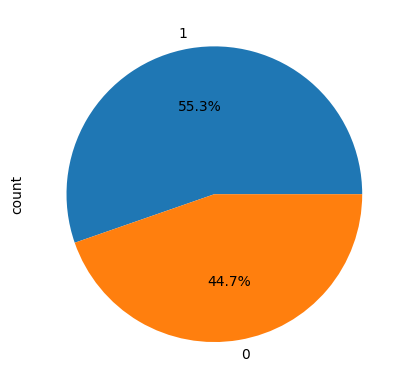

In [28]:
dataset['num'].value_counts().plot.pie(autopct = "%1.1f%%")

Required Preprocessing (learnt from previous notebooks)

In [29]:
# Handling trestbps outlier
print("Outlier in trestbps feature: ") # all of these outlier findings has been done in previous notebooks
print(dataset[dataset['trestbps']==0])
dataset['trestbps'] = dataset['trestbps'].replace(0, np.nan)
print(dataset['trestbps'].min(skipna = True))

# Handling oldpeak outlier
print("Outlier in oldpeak feature")
print(len(dataset[dataset['oldpeak'] <0]))
dataset['oldpeak']  = dataset['oldpeak'].clip(lower = 0, upper = 6)
print(len(dataset[dataset['oldpeak'] <0]))

# Splitting the dataset
X = dataset.iloc[:,1:-1]
y = dataset.iloc[: , -1].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("\nNumeric Features are: ")
print(dataset.select_dtypes(include=[np.number]).columns.tolist())

# Transformations

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

num_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
cat_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
num_pipeline = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'mean')),
        ('scaler', StandardScaler())
    ]
)
cat_pipeline = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'most_frequent')),
        ('encoder', OneHotEncoder(drop = 'first'))
    ]
)
preprocessor = ColumnTransformer(
    transformers = [
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ]
)

# Applying transformations

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print("After transformation, dataset is: ")
print(X_train[:5])
print(X_train.shape)

# creating a map

feature_names = (num_features +
                 list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)))

X_df = pd.DataFrame(X_train, columns = feature_names)
print(X_df.info())

Outlier in trestbps feature: 
      id  age   sex        dataset           cp  trestbps  chol    fbs  \
753  754   55  Male  VA Long Beach  non-anginal       0.0   0.0  False   

    restecg  thalch  exang  oldpeak slope  ca thal  num  
753  normal   155.0  False      1.5  flat NaN  NaN    1  
80.0
Outlier in oldpeak feature
12
0

Numeric Features are: 
['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'num']
After transformation, dataset is: 
[[ 9.02412547e-01  1.57774920e-15 -2.54935123e-01 -6.88473319e-01
   2.00217983e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 3.47761857e-02  1.00702194e+00  0.00000000e+00 -6.09262363e-01
  -8.55320196e-01  1.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.0000000

<Axes: ylabel='count'>

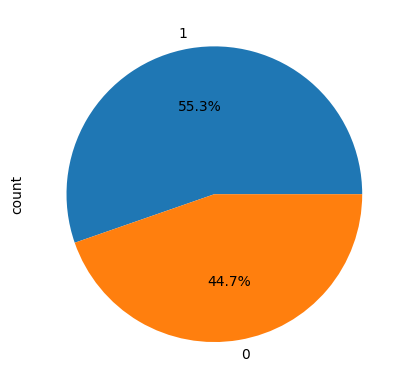

In [30]:
dataset['num'].value_counts().plot.pie(autopct = '%1.1f%%')

 Logistic Regression

In [31]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

Logistic Regression Results:
Accuracy: 0.8043

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77        75
           1       0.85      0.82      0.83       109

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.81      0.80      0.81       184


Confusion Matrix:
[[59 16]
 [20 89]]
AUC: 0.8015902140672782


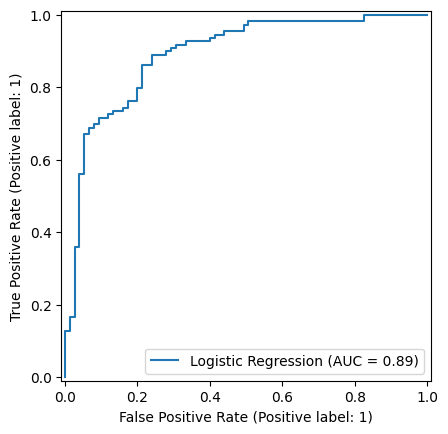

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

log_reg = LogisticRegression(random_state=42, max_iter = 1000)
log_reg.fit(X_train, y_train)

y_pred_log = log_reg.predict(X_test)
y_pred_proba_log = log_reg.predict_proba(X_test)[:, 1]

# Evaluation
print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_log))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_log)
auc_value = auc(fpr, tpr)
print(f"AUC: {auc_value}")

RocCurveDisplay.from_estimator(
    estimator = log_reg,
    X= X_test,
    y = y_test,
    name = "Logistic Regression"
)

Decision Trees

In [33]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42, max_depth=5)  # Limit depth to prevent overfitting
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_pred_proba_dt = dt.predict_proba(X_test)[:, 1]

# Evaluation
print("Decision Tree Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

Decision Tree Results:
Accuracy: 0.8370

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80        75
           1       0.86      0.87      0.86       109

    accuracy                           0.84       184
   macro avg       0.83      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184



Random Forest

X_train shape: (736, 20)
X_test shape: (184, 20)
Random Forest Results:
Accuracy: 0.8696

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84        75
           1       0.90      0.87      0.89       109

    accuracy                           0.87       184
   macro avg       0.86      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184


Top 10 Feature Importances:
    feature_index  importance
3               3    0.137626
2               2    0.131131
4               4    0.116870
12             12    0.099545
0               0    0.090039
6               6    0.079087
1               1    0.073439
5               5    0.072847
7               7    0.033883
18             18    0.029415
AUC: 0.8691131498470948


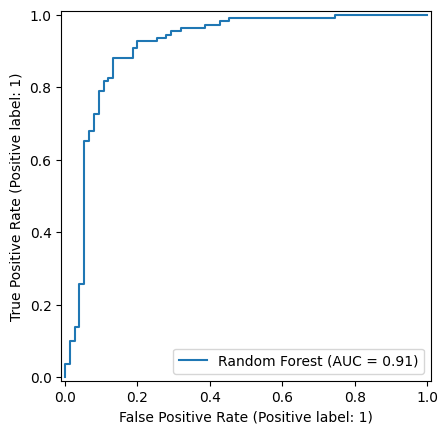

In [34]:
from sklearn.ensemble import RandomForestClassifier

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    n_jobs=-1,
    class_weight = 'balanced'
)
rf.fit(X_train, y_train)
y_pred_proba_rf = rf.predict_proba(X_test)
y_pred_rf = rf.predict(X_test)

print("Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

feature_importance = pd.DataFrame({
    'feature_index': range(X_train.shape[1]),
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feature_importance.head(10))


fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
auc_value = auc(fpr, tpr)
print(f"AUC: {auc_value}")

RocCurveDisplay.from_estimator(
    estimator = rf,
    X= X_test,
    y = y_test,
    name = "Random Forest"
)



In [35]:
from sklearn.model_selection import RandomizedSearchCV

param_dist =  {
    "n_estimators": [100, 300, 500, 700, 1000],
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "class_weight": ["balanced", None]
}
random_search = RandomizedSearchCV(
    estimator = rf,
    param_distributions = param_dist,
    scoring="roc_auc",
    n_iter = 50,
    cv = 5,
    random_state = 42,
    n_jobs = -1,
    verbose = 2
)
random_search.fit(X_train, y_train)
print("Best Params from RandomizedSearch:", random_search.best_params_)
print("Best CV Score (RandomizedSearch):", random_search.best_score_)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Params from RandomizedSearch: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 5, 'class_weight': None}
Best CV Score (RandomizedSearch): 0.8865336918349428


Random Forest Results:
Accuracy: 0.8696

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.84        75
           1       0.88      0.91      0.89       109

    accuracy                           0.87       184
   macro avg       0.87      0.86      0.86       184
weighted avg       0.87      0.87      0.87       184


Top 10 Feature Importances:
    feature_index  importance
4               4    0.152832
12             12    0.137249
6               6    0.131040
3               3    0.127153
2               2    0.107662
5               5    0.090254
0               0    0.059602
18             18    0.039461
7               7    0.032511
1               1    0.030696
AUC: 0.8607951070336392


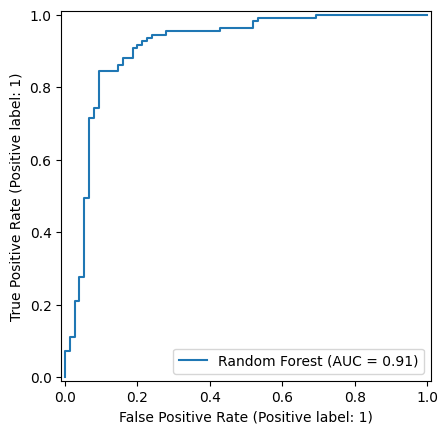

In [36]:
best_rf = RandomForestClassifier(
    n_estimators = 500,
    min_samples_split = 10,
    min_samples_leaf = 1,
    max_features = "log2",
    max_depth = 5,
    class_weight = None
)

best_rf.fit(X_train, y_train)
y_pred_proba_best_rf = best_rf.predict_proba(X_test)
y_pred_best_rf = best_rf.predict(X_test)

print("Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0))

feature_importance = pd.DataFrame({
    'feature_index': range(X_train.shape[1]),
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feature_importance.head(10))


fpr, tpr, thresholds = roc_curve(y_test, y_pred_best_rf)
auc_value = auc(fpr, tpr)
print(f"AUC: {auc_value}")

RocCurveDisplay.from_estimator(
    estimator = best_rf,
    X= X_test,
    y = y_test,
    name = "Random Forest"
)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:31:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Top 10 Feature Importances:
----------------------------
           feature  importance
        exang_True    0.242871
cp_atypical angina    0.114998
          sex_Male    0.087207
    cp_non-anginal    0.054984
       thal_normal    0.054401
           oldpeak    0.044341
 cp_typical angina    0.043888
   slope_upsloping    0.041838
              chol    0.039239
            ca_1.0    0.034213


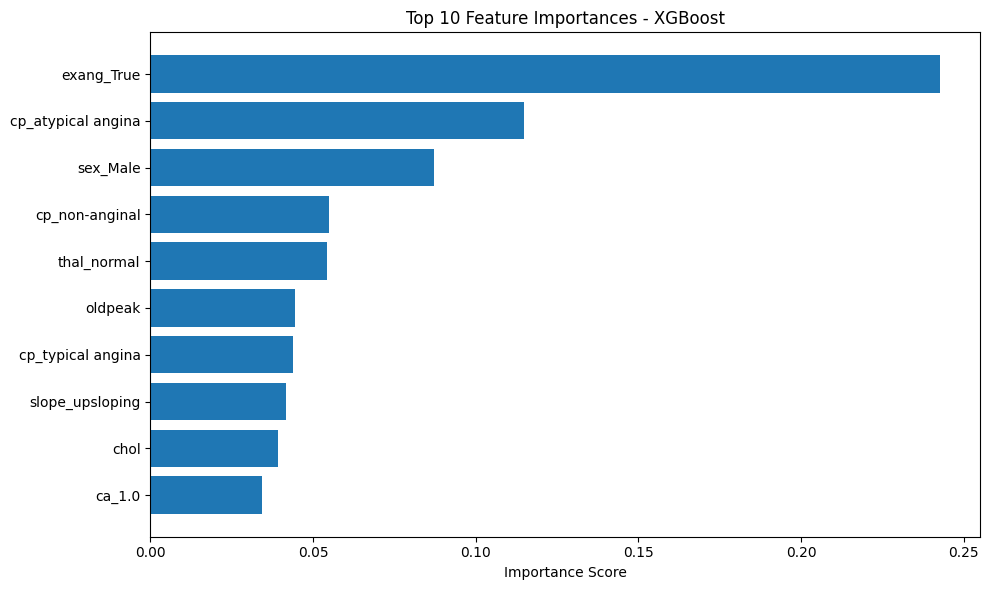


XGBoost Results:
Accuracy: 0.8696

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        75
           1       0.90      0.88      0.89       109

    accuracy                           0.87       184
   macro avg       0.86      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184

AUC: 0.8670336391437309


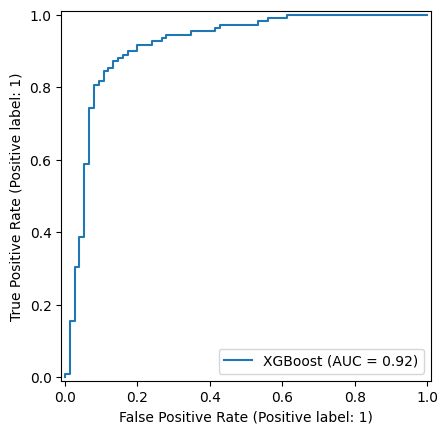

In [38]:
# First install if needed: pip install xgboost
try:
    import xgboost as xgb
    import pandas as pd
    import matplotlib.pyplot as plt

    # Initialize and train
    xgb_model = xgb.XGBClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train, y_train)

    # Get top 10 feature importances
    feature_importance = xgb_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': X_df.columns,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    top_10_features = feature_importance_df.head(10)
    print("\nTop 10 Feature Importances:")
    print("----------------------------")
    print(top_10_features.to_string(index=False))

    # Create bar plot visualization
    plt.figure(figsize=(10, 6))
    plt.barh(top_10_features['feature'], top_10_features['importance'])
    plt.xlabel('Importance Score')
    plt.title('Top 10 Feature Importances - XGBoost')
    plt.gca().invert_yaxis()  # Most important at the top
    plt.tight_layout()
    plt.show()

    y_pred_xgb = xgb_model.predict(X_test)
    y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

    print("\nXGBoost Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_xgb))

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgb)
    auc_value = auc(fpr, tpr)
    print(f"AUC: {auc_value}")

    RocCurveDisplay.from_estimator(
      estimator = xgb_model,  # Changed from 'rf' to 'xgb_model'
      X= X_test,
      y = y_test,
      name = "XGBoost"
    )

except ImportError:
    print("XGBoost not installed. Install with: pip install xgboost")

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

param_grid_xgb = {
    "n_estimators": [200, 300, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring="roc_auc",
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train)
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)


In [ ]:
best_xgb_model = grid_search_xgb.best_estimator_

best_xgb_model.fit(X_train, y_train)


y_pred_best_xgb = best_xgb_model.predict(X_test)
y_pred_proba_best_xgb = best_xgb_model.predict_proba(X_test)[:, 1]


print("best_xgboost Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_xgb))

In [ ]:
# Compare performance
models = {
    'Logistic Regression': y_pred_log,
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf
}

# Add XGBoost and LightGBM if available
if 'y_pred_xgb' in locals():
    models['XGBoost'] = y_pred_xgb
if 'y_pred_lgb' in locals():
    models['LightGBM'] = y_pred_lgb

print("Model Comparison:")
print("=" * 50)
for name, preds in models.items():
    acc = accuracy_score(y_test, preds)
    print(f"{name:<20}: {acc:.4f}")

# Create comparison DataFrame
results = pd.DataFrame({
    'Model': list(models.keys()),
    'Accuracy': [accuracy_score(y_test, preds) for preds in models.values()]
}).sort_values('Accuracy', ascending=False)

print("\nRanked Models by Accuracy:")
print(results)

In [ ]:
import joblib

joblib.dump(log_reg, "log_reg.pkl")
joblib.dump(rf, "rf.pkl")
joblib.dump(xgb_model, "xgb_model.pkl")
joblib.dump(dt, "dt.pkl")

In [ ]:
# Import necessary metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compare performance - Dictionary of your model names and their predictions
models = {
    'Logistic Regression': y_pred_log,
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf
}

# Add XGBoost and LightGBM if available
if 'y_pred_xgb' in locals():
    models['XGBoost'] = y_pred_xgb
if 'y_pred_lgb' in locals():
    models['LightGBM'] = y_pred_lgb

# Print detailed comparison
print("Model Comparison:")
print("=" * 65)
# Print header
print(f"{'Model':<20} | {'Accuracy':<8} | {'Precision':<8} | {'Recall':<8} | {'F1-Score':<8}")
print("-" * 65)

# Calculate and print metrics for each model - USING 'weighted' AVERAGE FOR MULTICLASS
for name, preds in models.items():
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)  # Changed for multiclass
    rec = recall_score(y_test, preds)      # Changed for multiclass
    f1 = f1_score(y_test, preds)           # Changed for multiclass
    print(f"{name:<20} | {acc:.4f}    | {prec:.4f}    | {rec:.4f}    | {f1:.4f}")

# Create comprehensive comparison DataFrame
results_list = []
for name, preds in models.items():
    results_list.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds, average='weighted'),  # Changed
        'Recall': recall_score(y_test, preds, average='weighted'),        # Changed
        'F1': f1_score(y_test, preds, average='weighted')                 # Changed
    })

results_df = pd.DataFrame(results_list)

# Sort by your preferred metric, e.g., F1-Score
results_df = results_df.sort_values('F1', ascending=False)

print("\nRanked Models by F1-Score:")
print("=" * 65)
print(results_df.to_string(index=False))